In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [2]:
%matplotlib inline

# 1d case

In [3]:
!ls 1d

data_ce_nx1024_kappa1em4.hdf5   data_imex_nx1024_kappa1em4.hdf5
data_ce_nx1024_kappa1em5.hdf5   data_imex_nx1024_kappa1em5.hdf5
data_ce_nx128_kappa1em3.hdf5    data_imex_nx128_kappa1em3.hdf5
data_ce_nx128_kappa1em4.hdf5    data_imex_nx128_kappa1em4.hdf5
data_ce_nx128_kappa1em5.hdf5    data_imex_nx128_kappa1em5.hdf5
data_ce_nx16_kappa1em3.hdf5     data_imex_nx16_kappa1em3.hdf5
data_ce_nx16_kappa1em4.hdf5     data_imex_nx16_kappa1em4.hdf5
data_ce_nx16_kappa1em5.hdf5     data_imex_nx16_kappa1em5.hdf5
data_ce_nx2048_kappa1em4.hdf5   data_imex_nx2048_kappa1em4.hdf5
data_ce_nx2048_kappa1em5.hdf5   data_imex_nx2048_kappa1em5.hdf5
data_ce_nx256_kappa1em3.hdf5    data_imex_nx256_kappa1em3.hdf5
data_ce_nx256_kappa1em4.hdf5    data_imex_nx256_kappa1em4.hdf5
data_ce_nx256_kappa1em5.hdf5    data_imex_nx256_kappa1em5.hdf5
data_ce_nx32_kappa1em3.hdf5     data_imex_nx32_kappa1em3.hdf5
data_ce_nx32_kappa1em4.hdf5     data_imex_nx32_kappa1em4.hdf5
data_ce_nx32_kappa1em5.hdf5     data_imex_nx32_kappa1em5

In [4]:
fs_imex_all = []
fs_ce_all = []
kappas = [1e-3, 1e-4, 1e-5]
for n in range(3, 3+len(kappas)):
    files_imex = sorted(glob.glob(f'1d/data_imex_*_kappa1em{n}.hdf5'), key=os.path.getmtime)
    fs_imex = []
    for f in files_imex:
        fs_imex.append(h5py.File(f, 'r'))
    fs_imex_all.append(fs_imex)
    files_ce = sorted(glob.glob(f'1d/data_ce_*_kappa1em{n}.hdf5'), key=os.path.getmtime)
    fs_ce = []
    for f in files_ce:
        fs_ce.append(h5py.File(f, 'r'))
    fs_ce_all.append(fs_ce)

In [5]:
print(len(fs_imex_all[0]), len(fs_ce_all[0]))
print(len(fs_imex_all[1]), len(fs_ce_all[1]))
print(len(fs_imex_all[2]), len(fs_ce_all[2]))

6 6
9 9
8 8


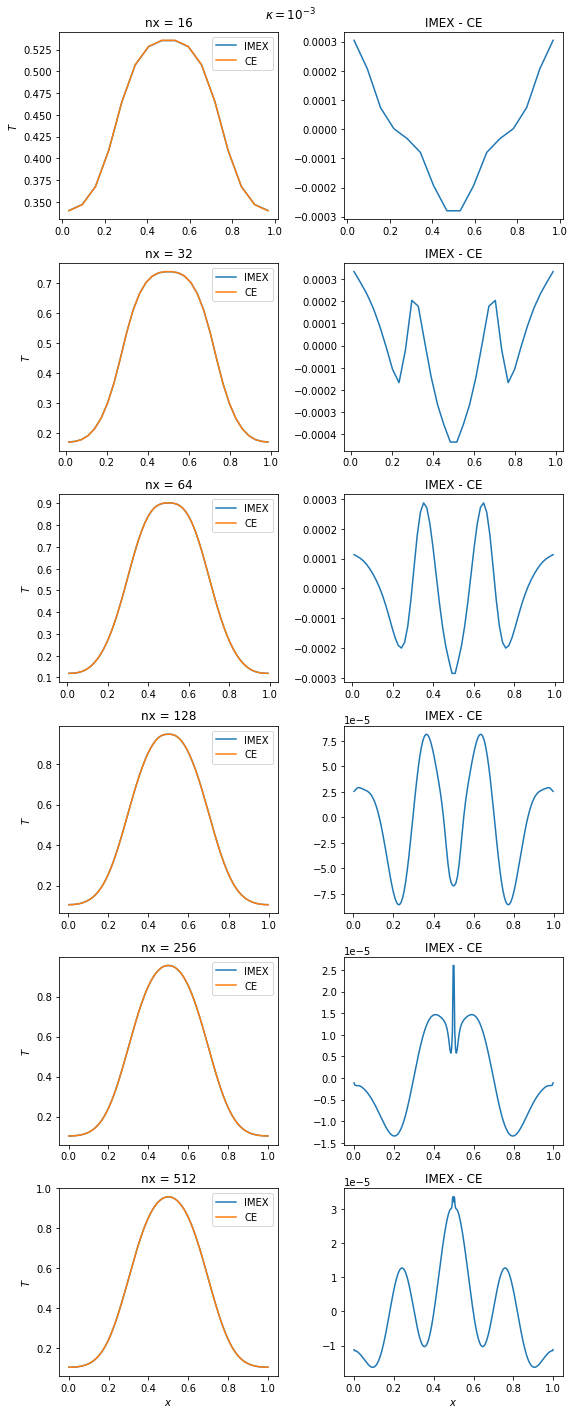

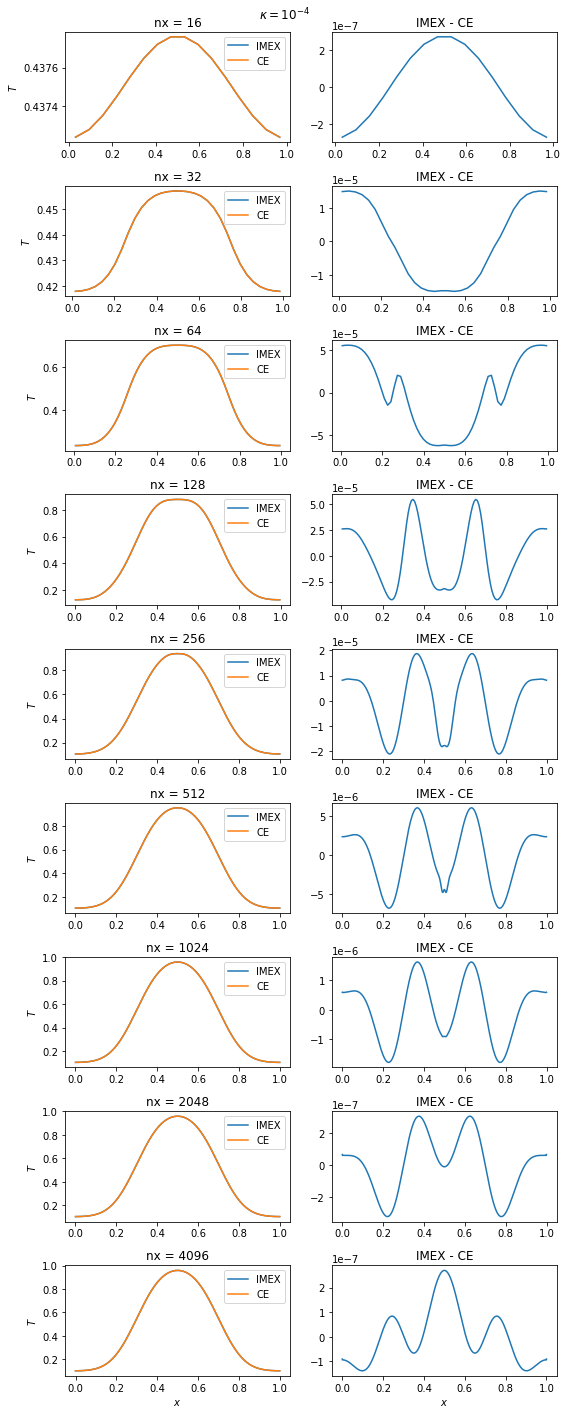

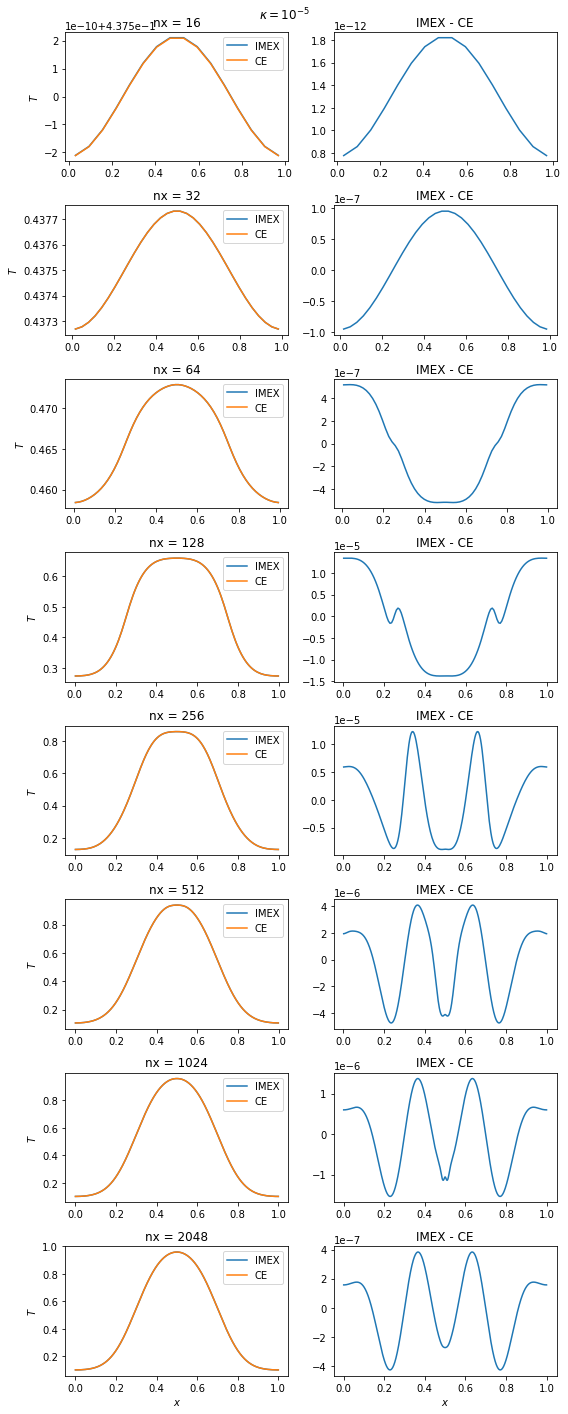

In [6]:
for n, kappa in enumerate(kappas):
    fig, axes = plt.subplots(len(fs_imex_all[n]), 2, figsize=(8, 20))
    for i in range(len(fs_imex_all[n])):
        axes[i, 0].plot(fs_imex_all[n][i]['Domain/x'], fs_imex_all[n][i]['Primitive/T'][:], label='IMEX')
        axes[i, 0].plot(fs_ce_all[n][i]['Domain/x'], fs_ce_all[n][i]['Primitive/T'][:], label='CE')
        axes[i, 0].legend()
        axes[i, 0].set_title(f"nx = {fs_imex_all[n][i]['Domain'].attrs['nx'][0]}")
        axes[i, 0].set_ylabel(r"$T$")
        axes[i, 1].plot(fs_imex_all[n][i]['Domain/x'], fs_imex_all[n][i]['Primitive/T'][:]-fs_ce_all[n][i]['Primitive/T'][:], label='IMEX')
        axes[i, 1].set_title("IMEX - CE")
    axes[-1, 0].set_xlabel(r"$x$")
    axes[-1, 1].set_xlabel(r"$x$")
    fig.suptitle(fr"$\kappa=10^{{-{3+n}}}$")
    fig.tight_layout()
    plt.show()

Needs self-convergence tests here as well.

In [7]:
def getCauchyConvergence(data, resolutions):
    cauchyerrors = []
    for i_r_c, r in enumerate(resolutions[1:]):
        i_r = i_r_c + 1
        data1 = data[i_r]['Primitive/T'][:]
        data2 = np.repeat(data[i_r_c]['Primitive/T'][:], 2)
        cauchyerrors.append(np.linalg.norm(data1-data2, 2) / r)
    return cauchyerrors

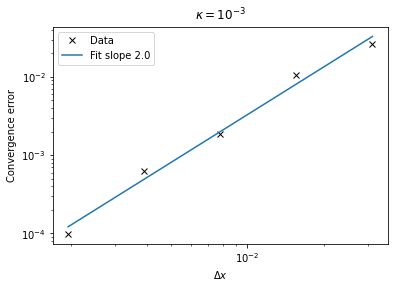

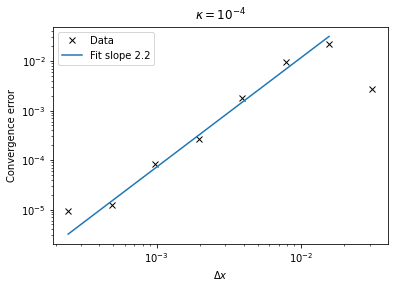

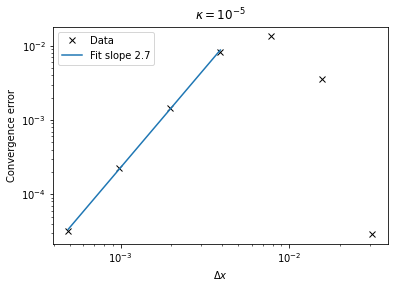

In [16]:
fit_ranges = [[0, 5],
              [1, 7],
              [3, 7]]
for n in range(len(fs_imex_all)):
    resolutions = []
    dxs = []
    for f in fs_imex_all[n]:
        resolutions.append(f['Domain'].attrs['nx'][0])
        dxs.append(f['Domain'].attrs['dx'][0])
    cauchyerrors = getCauchyConvergence(fs_imex_all[n], resolutions)
    p = np.polyfit(np.log(dxs[fit_ranges[n][0]+1:fit_ranges[n][1]+1]),
                   np.log(cauchyerrors[fit_ranges[n][0]:fit_ranges[n][1]]),
                   1)
    plt.figure()
    plt.loglog(dxs[1:], cauchyerrors, 'kx', label='Data')
    plt.loglog(dxs[1+fit_ranges[n][0]:], np.exp(p[1])*dxs[1+fit_ranges[n][0]:]**p[0], label=rf"Fit slope {p[0]:.1f}")
    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"Convergence error")
    plt.title(fr"IMEX: $\kappa=10^{{-{3+n}}}$")
    plt.legend()
    plt.show()


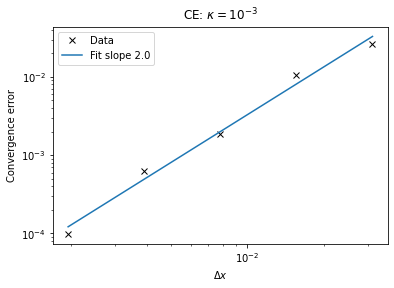

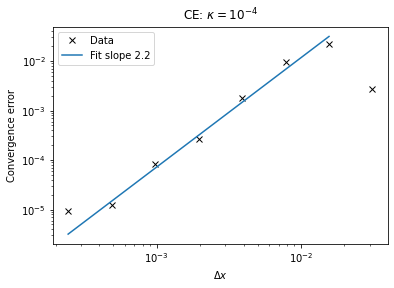

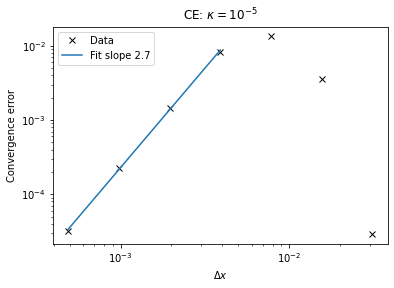

In [17]:
fit_ranges = [[0, 5],
              [1, 7],
              [3, 7]]
for n in range(len(fs_ce_all)):
    resolutions = []
    dxs = []
    for f in fs_ce_all[n]:
        resolutions.append(f['Domain'].attrs['nx'][0])
        dxs.append(f['Domain'].attrs['dx'][0])
    cauchyerrors = getCauchyConvergence(fs_ce_all[n], resolutions)
    p = np.polyfit(np.log(dxs[fit_ranges[n][0]+1:fit_ranges[n][1]+1]),
                   np.log(cauchyerrors[fit_ranges[n][0]:fit_ranges[n][1]]),
                   1)
    plt.figure()
    plt.loglog(dxs[1:], cauchyerrors, 'kx', label='Data')
    plt.loglog(dxs[1+fit_ranges[n][0]:], np.exp(p[1])*dxs[1+fit_ranges[n][0]:]**p[0], label=rf"Fit slope {p[0]:.1f}")
    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"Convergence error")
    plt.title(fr"CE: $\kappa=10^{{-{3+n}}}$")
    plt.legend()
    plt.show()


So, we are seeing self-convergence of each individually.

Check convergence of CE to full model by comparing one against the other, self-convergence style:

In [18]:
def getCauchyConvergence_twomodels(model1, model2, resolutions):
    cauchyerrors = []
    for i_r_c, r in enumerate(resolutions[1:]):
        i_r = i_r_c + 1
        data1 = model1[i_r]['Primitive/T'][:]
        data2 = np.repeat(model2[i_r_c]['Primitive/T'][:], 2)
        cauchyerrors.append(np.linalg.norm(data1-data2, 2) / r)
    return cauchyerrors

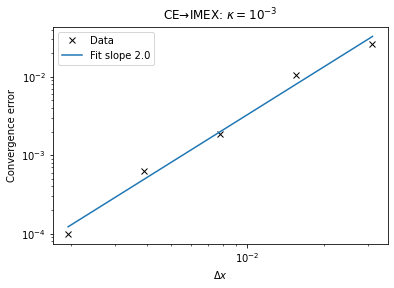

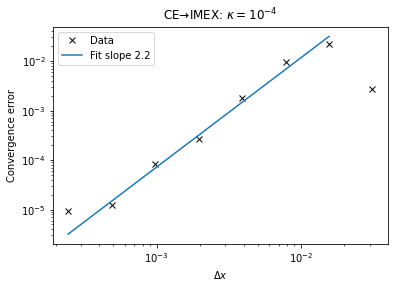

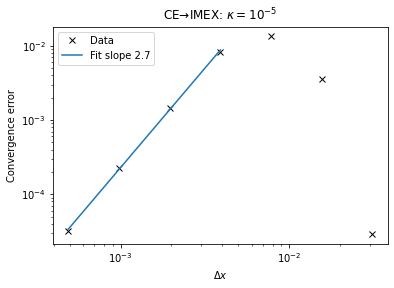

In [19]:
fit_ranges = [[0, 5],
              [1, 7],
              [3, 7]]
for n in range(len(fs_ce_all)):
    resolutions = []
    dxs = []
    for f in fs_ce_all[n]:
        resolutions.append(f['Domain'].attrs['nx'][0])
        dxs.append(f['Domain'].attrs['dx'][0])
    cauchyerrors = getCauchyConvergence_twomodels(fs_imex_all[n],
                                                  fs_ce_all[n],
                                                  resolutions)
    p = np.polyfit(np.log(dxs[fit_ranges[n][0]+1:fit_ranges[n][1]+1]),
                   np.log(cauchyerrors[fit_ranges[n][0]:fit_ranges[n][1]]),
                   1)
    plt.figure()
    plt.loglog(dxs[1:], cauchyerrors, 'kx', label='Data')
    plt.loglog(dxs[1+fit_ranges[n][0]:], np.exp(p[1])*dxs[1+fit_ranges[n][0]:]**p[0], label=rf"Fit slope {p[0]:.1f}")
    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"Convergence error")
    plt.title(fr"CE$\to$IMEX: $\kappa=10^{{-{3+n}}}$")
    plt.legend()
    plt.show()


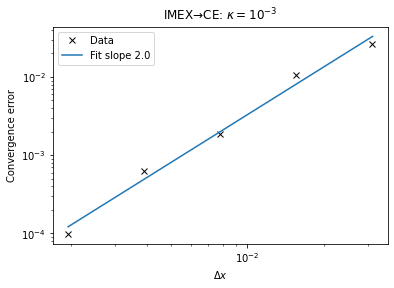

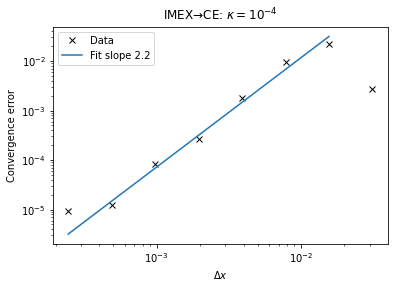

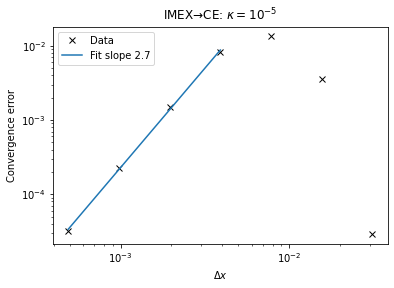

In [20]:
fit_ranges = [[0, 5],
              [1, 7],
              [3, 7]]
for n in range(len(fs_ce_all)):
    resolutions = []
    dxs = []
    for f in fs_ce_all[n]:
        resolutions.append(f['Domain'].attrs['nx'][0])
        dxs.append(f['Domain'].attrs['dx'][0])
    cauchyerrors = getCauchyConvergence_twomodels(fs_ce_all[n],
                                                  fs_imex_all[n],
                                                  resolutions)
    p = np.polyfit(np.log(dxs[fit_ranges[n][0]+1:fit_ranges[n][1]+1]),
                   np.log(cauchyerrors[fit_ranges[n][0]:fit_ranges[n][1]]),
                   1)
    plt.figure()
    plt.loglog(dxs[1:], cauchyerrors, 'kx', label='Data')
    plt.loglog(dxs[1+fit_ranges[n][0]:], np.exp(p[1])*dxs[1+fit_ranges[n][0]:]**p[0], label=rf"Fit slope {p[0]:.1f}")
    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"Convergence error")
    plt.title(fr"IMEX$\to$CE: $\kappa=10^{{-{3+n}}}$")
    plt.legend()
    plt.show()


So, all the convergence plots are essentially the same: to these limits of resolution, the two models are indistinguishable.